In [16]:
import tools
from matplotlib import pyplot as plt
import pandas as pd
from tkinter import filedialog

In [17]:
def ui_load_can_archive(file_path=None):
    # Se o caminho não for fornecido, abrir a caixa de diálogo para selecionar o arquivo
    if not file_path:
        file_path = filedialog.askopenfilename(
            title="Selecione o arquivo .CAN ou .TXT",
            filetypes=(("CAN files", "*.can"), ("TXT files", "*.txt"), ("all files", "*.*"))
        )

    # Verificar se o caminho foi fornecido ou selecionado
    if file_path:
        df = filetodataframe(file_path)  # Carrega os dados do arquivo
        return df
    else:
        print("Nenhum arquivo foi selecionado.")
        return None

In [18]:
def process_data(hex_data):
    # Verifica se a entrada é uma string
    if isinstance(hex_data, str):
        byte_list = hex_data.split(' ')

        # Verifica se a lista contém exatamente 8 bytes
        if len(byte_list) < 8:
            byte_list.extend(['00'] * (8 - len(byte_list)))

        # Converte os valores de hexadecimal para decimal, ignorando inválidos
        byte_list = [int(byte, 16) if is_valid_hex(byte) else 0 for byte in byte_list]

        return byte_list  # Retorna a lista de bytes convertida
    else:
        raise ValueError("A entrada deve ser uma string hexadecimal.")

In [19]:
def is_valid_hex(value):
    """Função para verificar se o valor é hexadecimal válido"""
    try:
        int(value, 16)
        return True
    except ValueError:
        return False

In [20]:
def filetodataframe(file_path):
    try:
        # Ler o arquivo .txt linha a linha
        with open(file_path, 'r') as file:
            lines = file.readlines()

        # Separar as colunas por ';' e montar a lista de dados
        data = []
        for line in lines:
            # Ignorar as linhas de cabeçalho e as que não têm a quantidade esperada de colunas
            if line.startswith("//") or "Logging" in line or "Microchip" in line:
                continue

            # Dividir os valores por ';'
            parts = line.strip().split(';')

            # Garantir que tenha o número mínimo de colunas para processar (pelo menos 5)
            if len(parts) < 5:
                continue

            # Extrair o ID e os bytes
            pgn = parts[2]  # PGN (ID)
            byte_count = int(parts[3])  # Número de bytes
            byte_values = parts[4:4 + byte_count]  # Extraindo os bytes reais

            # Preencher com '00' caso não tenha 8 bytes
            if len(byte_values) < 8:
                byte_values.extend(['00'] * (8 - len(byte_values)))

            # Adicionar a linha processada (PGN + 8 bytes)
            data.append([pgn] + byte_values[:8])  # Garantir que tenha no máximo 8 bytes

        # Converter a lista de dados em um DataFrame
        df = pd.DataFrame(data, columns=['pgn', 'Byte 1', 'Byte 2', 'Byte 3', 'Byte 4',
                                         'Byte 5', 'Byte 6', 'Byte 7', 'Byte 8'])

        # Aplicar a conversão de hexadecimal para decimal nas colunas de bytes e no PGN
        for i in range(1, 9):
            df[f'Byte {i}'] = df[f'Byte {i}'].apply(lambda x: int(x, 16) if is_valid_hex(x) else 0)

        # Converter o PGN de hexadecimal para decimal
        df['pgn'] = df['pgn'].apply(lambda x: int(x, 16) if is_valid_hex(x) else 0)

        return df

    except Exception as e:
        print(f"Erro ao carregar o arquivo: {e}")
        return None


In [21]:
df_raw = ui_load_can_archive("corolla/freio_5x_logFile.CAN")

In [22]:
df_raw.head()

,pgn,Byte 1,Byte 2,Byte 3,Byte 4,Byte 5,Byte 6,Byte 7,Byte 8
0,608,0,0,10,249,157,0,134,144
1,740,160,0,0,0,139,0,0,0
2,32,0,0,7,43,0,0,0,0
3,36,2,0,2,0,66,4,128,246
4,37,15,194,0,0,144,0,0,142


In [23]:
from tkinter import messagebox
filtro_byte = 5
filtro_pgn = 865
filtro_byte = f'Byte {filtro_byte}'
print(f"{filtro_byte} e {filtro_pgn}")

def filtrar_dataframe(df, pgn, byte):
    if df is None:
        messagebox.showwarning("Aviso", "Carregue um arquivo primeiro.")
        return None

    if pgn and byte:
        try:
            filtered_df = df[df['pgn'] == pgn]  # Se pgn for uma string hexadecimal
            # Verificar se o byte filtrado existe
            if byte in filtered_df.columns:
                # Filtrar os valores do byte especificado que não são 'FF' (255 em decimal)
                filtered_df = filtered_df[[byte]]
                #filtered_df = filtered_df[filtered_df[filtro_byte] != 255]
                filtered_df = filtered_df.rename(columns={byte: 'x'})

                if not filtered_df.empty:
                    return filtered_df
                else:
                    messagebox.showinfo("Informação", "Nenhum valor diferente de FF encontrado após filtrar.")
                    return None
            else:
                messagebox.showinfo("Informação", f"A coluna {byte} não existe.")
                return None
        except Exception as e:
            messagebox.showerror("Erro", f"Erro ao aplicar filtros: {str(e)}")
            return None
    else:
        messagebox.showwarning("Aviso", "Preencha os campos de filtro antes de filtrar.")
        return None

Byte 5 e 865


In [24]:
def vizdata(df):
    if df is None:
        messagebox.showwarning("Aviso", "Carregue um arquivo primeiro.")
        return

    # Visualização da coluna específica
    plt.figure(figsize=(20, 10), dpi=100)
    plt.plot(range(len(df)), df['x'], linestyle='-', color='b',
             linewidth=0.7, label='x')
    plt.xlabel('X')
    plt.ylabel('Value')
    plt.title(f"Visualização de Dados - PGN: {filtro_pgn}, Byte: {filtro_byte}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [25]:
filtered_df_one = filtrar_dataframe(df_raw, filtro_pgn, filtro_byte)

filtered_df_one.head(20)

,x
58,22
71,22
207,22
252,22
280,22
297,22
336,22
470,22
600,22
613,22


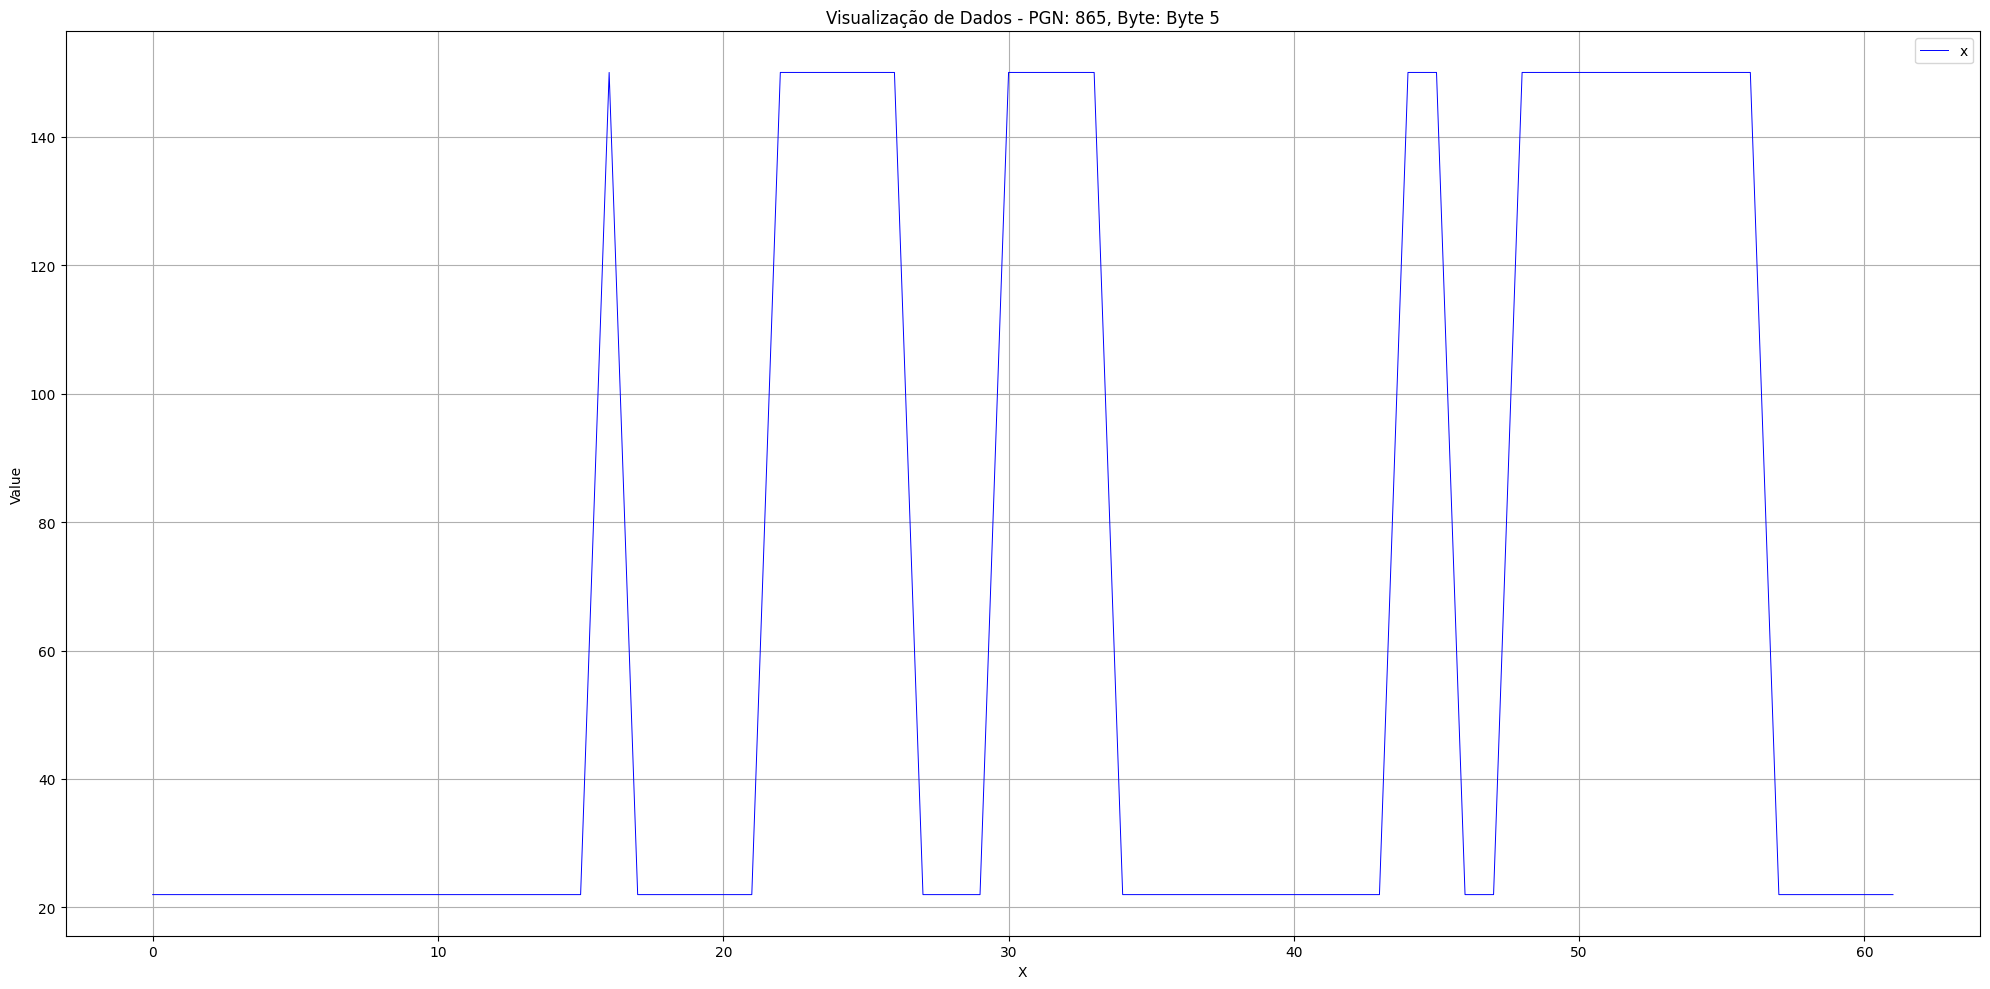

In [26]:
vizdata(filtered_df_one)


In [27]:
filtered_df_one.count()

x    62
dtype: int64

In [28]:
def repeat_values_in_dataframe_corrected(df):
    if 'x' in df.columns:
        # Cria um novo dataframe vazio para armazenar os valores repetidos
        df_result = pd.DataFrame(columns=['x'])
        
        # Primeiro loop para percorrer cada linha do dataframe original
        rows = []
        for i in range(len(df)):
            value = df.iloc[i, 0]  # Obtém o valor da primeira coluna (coluna 'x')
            
            # Segundo loop para repetir o valor 10 vezes
            for _ in range(10):
                rows.append(value)
        
        # Concatena as listas no DataFrame final
        df_result = pd.concat([pd.DataFrame({'x': rows})], ignore_index=True)
        
        return df_result
    else:
        return "Coluna 'x' não encontrada"


In [29]:
# Expandindo o DataFrame com o novo loop
df_expanded_loop = repeat_values_in_dataframe_corrected(filtered_df_one)

# Exibindo o DataFrame resultante para o usuário

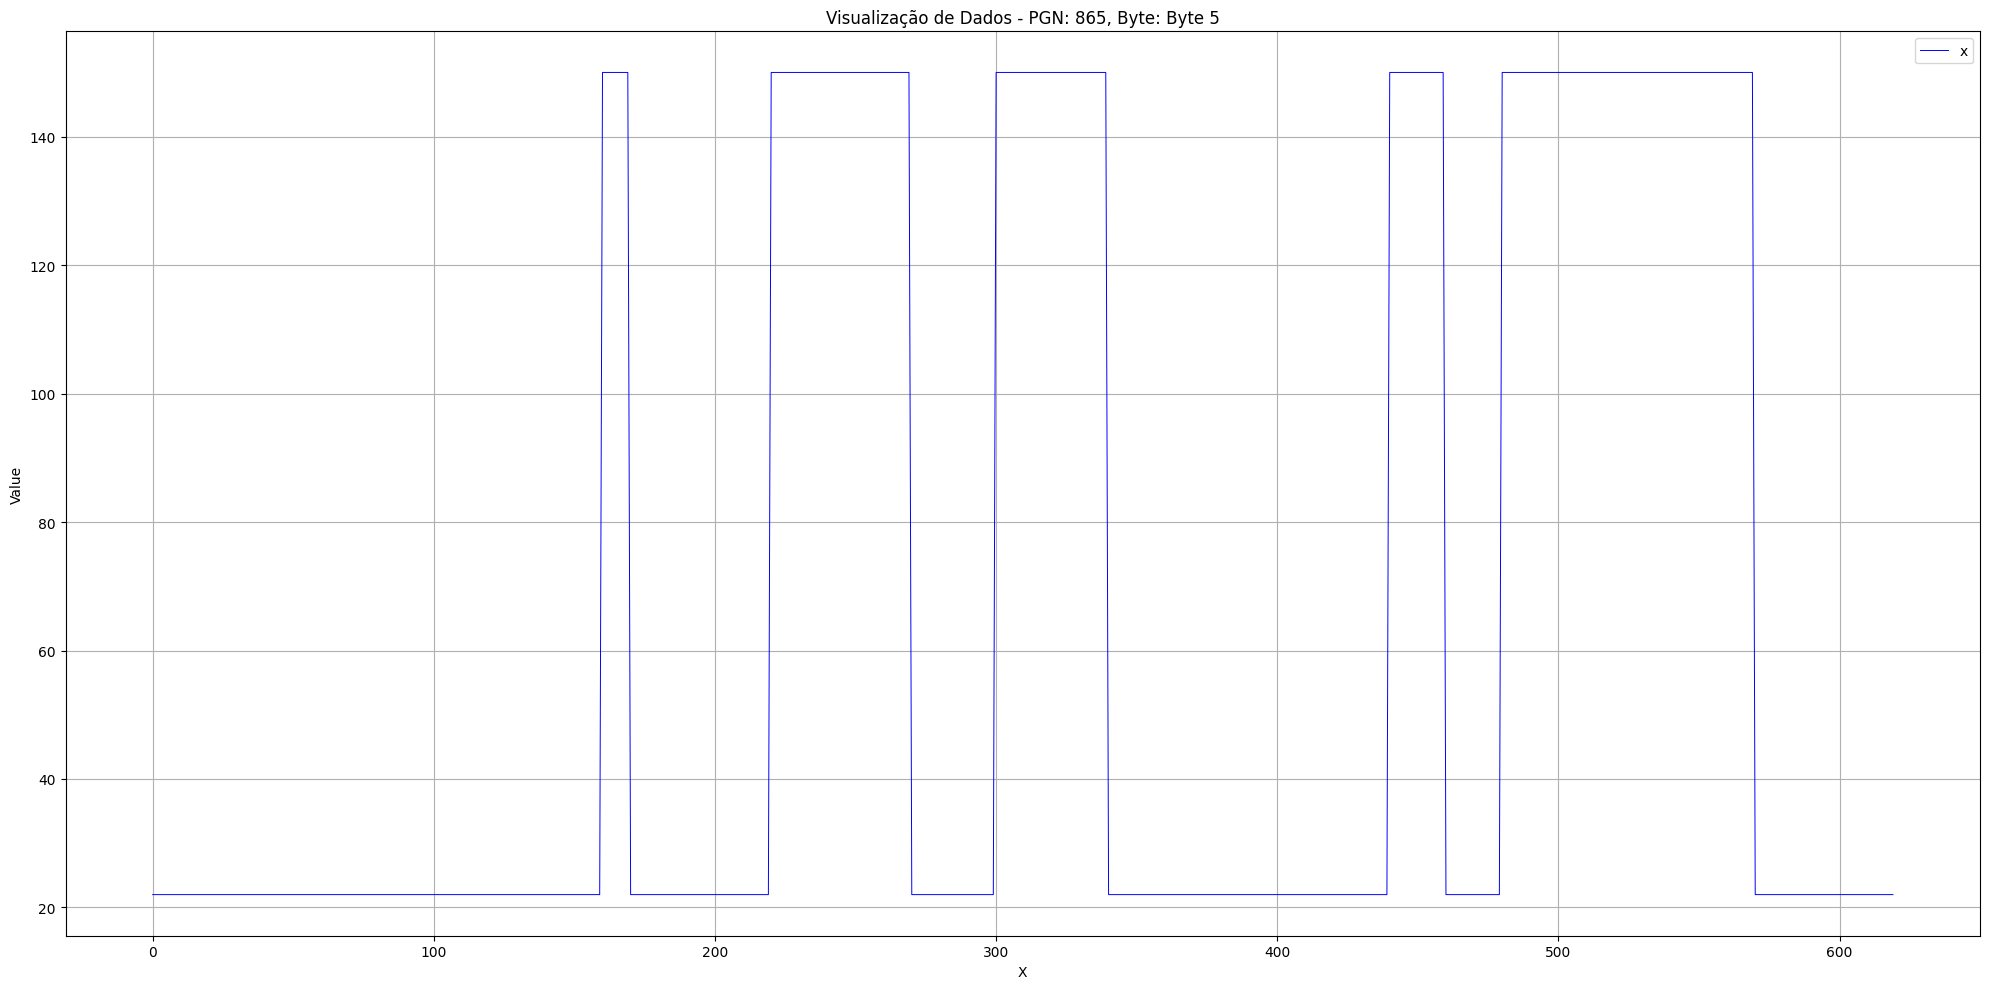

In [30]:
vizdata(df_expanded_loop)